# Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection

In [1]:
import numpy as np 
import pandas as pd
import torch
# from data_loader import *
# from main import *
from tqdm import tqdm
from PIL import Image
import os

root = '/home/genta/dataset/DAGM2007/Class1/'
fnames = os.listdir(root)

np_imgs = []
for fname in fnames:
    im = Image.open(os.path.join(root, fname))
    np_imgs.append(np.asarray(im))
    
np_imgs = np.asarray(np_imgs).astype(np.float32)/255.
print(np_imgs.shape)
np_imgs_mean = np_imgs.mean(axis=0)
np_imgs_var = np_imgs.var(axis=0)
np_imgs = (np_imgs - np_imgs_mean) / np.sqrt(np_imgs_var)
np_imgs = np_imgs.astype(np.float64)

np_imgs = np_imgs.reshape(-1, 512*512)

(1000, 512, 512)


In [2]:
# %load main.py
import os
import argparse
# from solver import Solver
# from data_loader import get_loader
from torch.backends import cudnn
from utils import *

def str2bool(v):
    return v.lower() in ('true')

def main(config):
    # For fast training
    cudnn.benchmark = True

    # Create directories if not exist
    mkdir(config.log_path)
    mkdir(config.model_save_path)

    data_loader = get_loader(config.data_path, batch_size=config.batch_size, mode=config.mode)
    
    # Solver
    solver = Solver(data_loader, vars(config))

    if config.mode == 'train':
        solver.train()
    elif config.mode == 'test':
        solver.test()

    return solver

In [11]:
# %load solver.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime
from torch.autograd import grad
from torch.autograd import Variable
from model import *
import matplotlib.pyplot as plt
from utils import *
# from data_loader import *
import IPython
from tqdm import tqdm

class Solver(object):
    DEFAULTS = {}   
    def __init__(self, data_loader, config):
        # Data loader
        self.__dict__.update(Solver.DEFAULTS, **config)
        self.data_loader = data_loader

        # Build tensorboard if use
        self.build_model()
        if self.use_tensorboard:
            self.build_tensorboard()

        # Start with trained model
        if self.pretrained_model:
            self.load_pretrained_model()

    def build_model(self):
        # Define model
        self.dagmm = DaGMM(input_size=self.data_loader.dataset.D, n_gmm=self.gmm_k)

        # Optimizers
        self.optimizer = torch.optim.Adam(self.dagmm.parameters(), lr=self.lr)

        # Print networks
        self.print_network(self.dagmm, 'DaGMM')

        if torch.cuda.is_available():
            self.dagmm.cuda()

    def print_network(self, model, name):
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(name)
        print(model)
        print("The number of parameters: {}".format(num_params))

    def load_pretrained_model(self):
        self.dagmm.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_dagmm.pth'.format(self.pretrained_model))))

        print("phi", self.dagmm.phi,"mu",self.dagmm.mu, "cov",self.dagmm.cov)

        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    def build_tensorboard(self):
        from logger import Logger
        self.logger = Logger(self.log_path)

    def reset_grad(self):
        self.dagmm.zero_grad()

    def to_var(self, x, volatile=False):
        if torch.cuda.is_available():
            x = x.cuda()
        return Variable(x, volatile=volatile)

    def train(self):
        iters_per_epoch = len(self.data_loader)

        # Start with trained model if exists
        if self.pretrained_model:
            start = int(self.pretrained_model.split('_')[0])
        else:
            start = 0

        # Start training
        iter_ctr = 0
        start_time = time.time()



        self.ap_global_train = np.array([0,0,0])
        for e in range(start, self.num_epochs):
            for i, (input_data, labels) in enumerate(tqdm(self.data_loader)):
                iter_ctr += 1
                start = time.time()

                input_data = self.to_var(input_data)

                total_loss,sample_energy, recon_error, cov_diag = self.dagmm_step(input_data)
                # Logging
                loss = {}
                loss['total_loss'] = total_loss.data.item()
                loss['sample_energy'] = sample_energy.item()
                loss['recon_error'] = recon_error.item()
                loss['cov_diag'] = cov_diag.item()



                # Print out log info
                if (i+1) % self.log_step == -1:
                    elapsed = time.time() - start_time
                    total_time = ((self.num_epochs*iters_per_epoch)-(e*iters_per_epoch+i)) * elapsed/(e*iters_per_epoch+i+1)
                    epoch_time = (iters_per_epoch-i)* elapsed/(e*iters_per_epoch+i+1)
                    
                    epoch_time = str(datetime.timedelta(seconds=epoch_time))
                    total_time = str(datetime.timedelta(seconds=total_time))
                    elapsed = str(datetime.timedelta(seconds=elapsed))

                    lr_tmp = []
                    for param_group in self.optimizer.param_groups:
                        lr_tmp.append(param_group['lr'])
                    tmplr = np.squeeze(np.array(lr_tmp))

                    log = "Elapsed {}/{} -- {} , Epoch [{}/{}], Iter [{}/{}], lr {}".format(
                        elapsed,epoch_time,total_time, e+1, self.num_epochs, i+1, iters_per_epoch, tmplr)

                    for tag, value in loss.items():
                        log += ", {}: {:.4f}".format(tag, value)

                    IPython.display.clear_output()
                    print(log)

                    if self.use_tensorboard:
                        for tag, value in loss.items():
                            self.logger.scalar_summary(tag, value, e * iters_per_epoch + i + 1)
                    else:
                        plt_ctr = 1
                        if not hasattr(self,"loss_logs"):
                            self.loss_logs = {}
                            for loss_key in loss:
                                self.loss_logs[loss_key] = [loss[loss_key]]
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1
                        else:
                            for loss_key in loss:
                                self.loss_logs[loss_key].append(loss[loss_key])
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1

                        plt.show()

                    print("phi", self.dagmm.phi,"mu",self.dagmm.mu, "cov",self.dagmm.cov)
                # Save model checkpoints
                if (i+1) % self.model_save_step == 0:
                    torch.save(self.dagmm.state_dict(),
                        os.path.join(self.model_save_path, '{}_{}_dagmm.pth'.format(e+1, i+1)))

    def dagmm_step(self, input_data):
        self.dagmm.train()
        enc, dec, z, gamma = self.dagmm(input_data)

        total_loss, sample_energy, recon_error, cov_diag = self.dagmm.loss_function(input_data, dec, z, gamma, self.lambda_energy, self.lambda_cov_diag)

        self.reset_grad()
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.dagmm.parameters(), 5)
        self.optimizer.step()

        return total_loss,sample_energy, recon_error, cov_diag

    def test(self):
        print("======================TEST MODE======================")
        self.dagmm.eval()
        self.data_loader.dataset.mode="train"

        N = 0
        mu_sum = 0
        cov_sum = 0
        gamma_sum = 0

        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            phi, mu, cov = self.dagmm.compute_gmm_params(z, gamma)
            
            batch_gamma_sum = torch.sum(gamma, dim=0)
            
            gamma_sum += batch_gamma_sum
            mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
            cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
            
            N += input_data.size(0)
            
        train_phi = gamma_sum / N
        train_mu = mu_sum / gamma_sum.unsqueeze(-1)
        train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

        print("N:",N)
        print("phi :\n",train_phi)
        print("mu :\n",train_mu)
        print("cov :\n",train_cov)

        train_energy = []
        train_labels = []
        train_z = []
        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            sample_energy, cov_diag = self.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
            
            train_energy.append(sample_energy.data.cpu().numpy())
            train_z.append(z.data.cpu().numpy())
            train_labels.append(labels.numpy())


        train_energy = np.concatenate(train_energy,axis=0)
        train_z = np.concatenate(train_z,axis=0)
        train_labels = np.concatenate(train_labels,axis=0)


        self.data_loader.dataset.mode="test"
        test_energy = []
        test_labels = []
        test_z = []
        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            sample_energy, cov_diag = self.dagmm.compute_energy(z, size_average=False)
            test_energy.append(sample_energy.data.cpu().numpy())
            test_z.append(z.data.cpu().numpy())
            test_labels.append(labels.numpy())


        test_energy = np.concatenate(test_energy,axis=0)
        test_z = np.concatenate(test_z,axis=0)
        test_labels = np.concatenate(test_labels,axis=0)

        combined_energy = np.concatenate([train_energy, test_energy], axis=0)
        combined_labels = np.concatenate([train_labels, test_labels], axis=0)

        thresh = np.percentile(combined_energy, 100 - 20)
        print("Threshold :", thresh)

        pred = (test_energy > thresh).astype(int)
        gt = test_labels.astype(int)

        from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

        accuracy = accuracy_score(gt,pred)
        precision, recall, f_score, support = prf(gt, pred, average='binary')

        print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy, precision, recall, f_score))
        
        return accuracy, precision, recall, f_score

In [12]:
np_imgs.mean(), np_imgs.min(), np_imgs.max()

(0.0021973488558790057, -2.7661571502685547, 7.421413421630859)

In [13]:
# %load data_loader.py
import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import h5py
import numpy as np
import collections
import numbers
import math
import pandas as pd
class KDD99Loader(object):
    def __init__(self, data_path, mode="train"):
        self.mode=mode
        if data_path is None:
            data_path = './kdd_cup.npz'
        data = np.load(data_path)

        labels = data["kdd"][:,-1]
        features = data["kdd"][:,:-1]
        N, D = features.shape
        self.D = D
        normal_data = features[labels==1]
        normal_labels = labels[labels==1]

        N_normal = normal_data.shape[0]

        attack_data = features[labels==0]
        attack_labels = labels[labels==0]

        N_attack = attack_data.shape[0]

        randIdx = np.arange(N_attack)
        np.random.shuffle(randIdx)
        N_train = N_attack // 2

        self.train = attack_data[randIdx[:N_train]]
        self.train_labels = attack_labels[randIdx[:N_train]]

        self.test = attack_data[randIdx[N_train:]]
        self.test_labels = attack_labels[randIdx[N_train:]]

        self.test = np.concatenate((self.test, normal_data),axis=0)
        self.test_labels = np.concatenate((self.test_labels, normal_labels),axis=0)


    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return self.train.shape[0]
        else:
            return self.test.shape[0]


    def __getitem__(self, index):
        if self.mode == "train":
            return np.float32(self.train[index]), np.float32(self.train_labels[index])
        else:
            return np.float32(self.test[index]), np.float32(self.test_labels[index])
        

class DAGM2007Loader(KDD99Loader):
    def __init__(self, data_path, mode="train"):
        self.mode=mode
#         data = np.load(data_path)
#         labels = data["kdd"][:,-1]
#         features = data["kdd"][:,:-1]
        features = np_imgs.reshape(np_imgs.shape[0], -1)
        x_train = features[:len(np_imgs)//2]
        x_test = features[len(np_imgs)//2:len(np_imgs)//2+100]
        N, D = features.shape
        y_train = np.ones(len(x_train))
        y_test = np.ones(len(x_test))
        self.D = D
        np.random.seed(2)
        x_test[:5] = np.random.rand(*x_test[:5].shape) + x_train.mean()
        y_test[:5] = 0
#         perm = np.random.permutation(N)
#         labels = np.concatenate((y_train, y_test), axis=0)
#         print(features.shape)
#         print(labels.shape)

#         normal_data = features[labels==1]
#         normal_labels = labels[labels==1]

#         N_normal = normal_data.shape[0]

#         attack_data = features[labels==0]
#         attack_labels = labels[labels==0]

#         N_attack = attack_data.shape[0]

#         randIdx = np.arange(N_attack)
#         np.random.shuffle(randIdx)
#         N_train = N_attack // 2
        self.train = x_train
        self.train_labels = y_train
        
        self.test = x_test
        self.test_labels = y_test

        print(len(self.train))

#         self.train = attack_data[randIdx[:N_train]]
#         self.train_labels = attack_labels[randIdx[:N_train]]

#         self.test = attack_data[randIdx[N_train:]]
#         self.test_labels = attack_labels[randIdx[N_train:]]

#         self.test = np.concatenate((self.test, normal_data),axis=0)
#         self.test_labels = np.concatenate((self.test_labels, normal_labels),axis=0)
    
    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return self.train.shape[0]
        else:
            return self.test.shape[0]


    def __getitem__(self, index):
        if self.mode == "train":
            return np.float32(self.train[index]), np.float32(self.train_labels[index])
        else:
            return np.float32(self.test[index]), np.float32(self.test_labels[index])
    
def get_loader(data_path, batch_size, mode='train', loader=None):
    """Build and return data loader."""

    if loader is not None:
        dataset = loader(data_path, mode)
    else:
        dataset = DAGM2007Loader(data_path, mode=mode)
#         dataset = KDD99Loader(data_path, mode=mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle)
    return data_loader


In [14]:
torch.__version__

'1.0.0'

In [15]:
# %load model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch.autograd import Variable
import itertools
from utils import *

class Cholesky(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a):
        l = torch.potrf(a, False)
        ctx.save_for_backward(l)
        return l
    @staticmethod
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        linv = l.inverse()
        inner = torch.tril(torch.mm(l.t(), grad_output)) * torch.tril(
            1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s

class DaGMM(nn.Module):
    """Residual Block."""
    def __init__(self, input_size=118, n_gmm=2, latent_dim=3):
        super(DaGMM, self).__init__()

        layers = []
        layers += [nn.Linear(input_size,60)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(60,30)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(30,10)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(10,1)]

        self.encoder = nn.Sequential(*layers)


        layers = []
        layers += [nn.Linear(1,10)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(10,30)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(30,60)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(60,input_size)]

        self.decoder = nn.Sequential(*layers)

        layers = []
        layers += [nn.Linear(latent_dim,10)]
        layers += [nn.Tanh()]        
        layers += [nn.Dropout(p=0.5)]        
        layers += [nn.Linear(10,n_gmm)]
        layers += [nn.Softmax(dim=1)]


        self.estimation = nn.Sequential(*layers)

        self.register_buffer("phi", torch.zeros(n_gmm))
        self.register_buffer("mu", torch.zeros(n_gmm,latent_dim))
        self.register_buffer("cov", torch.zeros(n_gmm,latent_dim,latent_dim))

    def relative_euclidean_distance(self, a, b):
        return (a-b).norm(2, dim=1) / a.norm(2, dim=1)

    def forward(self, x):

        enc = self.encoder(x)

        dec = self.decoder(enc)

        rec_cosine = F.cosine_similarity(x, dec, dim=1)
        rec_euclidean = self.relative_euclidean_distance(x, dec)

        z = torch.cat([enc, rec_euclidean.unsqueeze(-1), rec_cosine.unsqueeze(-1)], dim=1)

        gamma = self.estimation(z)

        return enc, dec, z, gamma

    def compute_gmm_params(self, z, gamma):
        N = gamma.size(0)
        # K
        sum_gamma = torch.sum(gamma, dim=0)

        # K
        phi = (sum_gamma / N)

        self.phi = phi.data

 
        # K x D
        mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
        self.mu = mu.data
        # z = N x D
        # mu = K x D
        # gamma N x K

        # z_mu = N x K x D
        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        # z_mu_outer = N x K x D x D
        z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)

        # K x D x D
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        self.cov = cov.data

        return phi, mu, cov
        
    def compute_energy(self, z, phi=None, mu=None, cov=None, size_average=True):
        if phi is None:
            phi = to_var(self.phi)
        if mu is None:
            mu = to_var(self.mu)
        if cov is None:
            cov = to_var(self.cov)

        k, D, _ = cov.size()

        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))
        print(z_mu)

        eps = 1e-6
        cov_K = cov + to_var(torch.cat([torch.eye(D).unsqueeze(0) for i in range(k)])) * eps
        L = torch.cholesky(cov_K)
        v = torch.einsum('ijk,jnk->ijn', z_mu, torch.inverse(L))
        det_cov = torch.prod(L[:, range(D), range(D)], dim=1)
        cov_diag = torch.sum(1 / cov_K[:, range(D), range(D)])

        # N x K
        exp_term_tmp = -0.5 * torch.einsum('ijk,ijk->ij', v, v)
    
        dlog = D * np.log(2*np.pi)
        sample_energy = - torch.logsumexp(torch.log(phi.unsqueeze(0)) + exp_term_tmp - 0.5*(dlog + torch.log(det_cov)), dim=1)


        if size_average:
            sample_energy = torch.mean(sample_energy)

        return sample_energy, cov_diag


    def loss_function(self, x, x_hat, z, gamma, lambda_energy, lambda_cov_diag):

        recon_error = torch.mean((x - x_hat) ** 2)

        phi, mu, cov = self.compute_gmm_params(z, gamma)

        sample_energy, cov_diag = self.compute_energy(z, phi, mu, cov)

        loss = recon_error + lambda_energy * sample_energy + lambda_cov_diag * cov_diag

        return loss, sample_energy, recon_error, cov_diag


In [16]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 1,
    'batch_size' : 1,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

In [17]:
%%time
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

500


  1%|          | 4/500 [00:00<00:14, 33.82it/s]

DaGMM
DaGMM(
  (encoder): Sequential(
    (0): Linear(in_features=262144, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=60, bias=True)
    (5): Tanh()
    (6): Linear(in_features=60, out_features=262144, bias=True)
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=10, out_features=4, bias=True)
    (4): Softmax()
  )
)
The number of parameters: 31723929
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
 

  2%|▏         | 12/500 [00:00<00:14, 34.74it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-5.9605e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.9605e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad

  4%|▍         | 20/500 [00:00<00:13, 35.34it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [9.3132e-10, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.9802e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  2.9104e-11],
         [ 0.0000e+00,  0.0000e+00, -2.9104e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBack

  6%|▌         | 28/500 [00:00<00:13, 35.34it/s]

tensor([[[-2.9802e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.9802e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.9802e-08,  0.0000e+00,  0.0000e+00],
         [ 2.9802e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-5.9605e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.9802e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00,

  7%|▋         | 36/500 [00:01<00:12, 35.74it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[2.9802e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=

  9%|▉         | 44/500 [00:01<00:13, 34.67it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.9605e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  

 10%|█         | 52/500 [00:01<00:13, 34.38it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], d

 11%|█         | 56/500 [00:01<00:12, 34.36it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 2.9104e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 2.9802e-08,  0.0000e+00,  0.0000e+00],
         [-2.9802e-08,  0.0000e+00,  

 13%|█▎        | 64/500 [00:01<00:12, 34.87it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.9802e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tens

 14%|█▍        | 72/500 [00:02<00:12, 34.08it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4901e-08, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=

 16%|█▌        | 80/500 [00:02<00:12, 34.21it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       

 18%|█▊        | 88/500 [00:02<00:12, 34.04it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -1.4552e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tens

 18%|█▊        | 92/500 [00:02<00:12, 33.76it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4901e-08, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  5.8208e-11],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.9104e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11],
         [0.0000e+00, 0.0000e+00,

 20%|██        | 100/500 [00:02<00:11, 34.39it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4901e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBack

 22%|██▏       | 108/500 [00:03<00:11, 34.88it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  2.3283e-10],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
 

 23%|██▎       | 116/500 [00:03<00:11, 33.11it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.7253e-09, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  1.1642e-10],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 1.4901e-08,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0

 25%|██▍       | 124/500 [00:03<00:11, 33.27it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  5.8208e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBack

 26%|██▋       | 132/500 [00:03<00:10, 34.55it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 4.6566e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBack

 28%|██▊       | 140/500 [00:04<00:10, 34.43it/s]

tensor([[[-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 7.2760e-12],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -2.9104e-11],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBack

 29%|██▉       | 144/500 [00:04<00:10, 34.03it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.7253e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -3.6380e-12]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tens

 30%|███       | 152/500 [00:04<00:10, 34.73it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-7.4506e-09,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
      

 32%|███▏      | 160/500 [00:04<00:09, 34.88it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.8208e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBack

 34%|███▎      | 168/500 [00:04<00:09, 34.77it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
       

 35%|███▌      | 176/500 [00:05<00:09, 35.37it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 

 37%|███▋      | 184/500 [00:05<00:09, 34.86it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -7.2760e-12],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -7.2760e-12],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
   

 38%|███▊      | 192/500 [00:05<00:08, 35.56it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  1.1642e-10],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
 

 40%|████      | 200/500 [00:06<00:12, 23.74it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-9.3132e-10,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+

 42%|████▏     | 208/500 [00:06<00:10, 28.21it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+

 42%|████▏     | 212/500 [00:06<00:09, 30.22it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.8208e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  2.3283e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       

 44%|████▍     | 220/500 [00:06<00:08, 33.01it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  2.9104e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10]]], device='cuda:0',
       grad

 46%|████▌     | 228/500 [00:06<00:07, 34.65it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
   

 47%|████▋     | 236/500 [00:07<00:07, 35.40it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-4.6566e-10,  0.0000e+00,  2.9104e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-3.7253e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00,

 49%|████▉     | 244/500 [00:07<00:07, 35.72it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[1.8626e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.8626e-09, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:

 50%|█████     | 252/500 [00:07<00:06, 35.92it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 9.3132e-10,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.9104e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-4.6566e-10,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], d

 52%|█████▏    | 260/500 [00:07<00:06, 36.22it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[3.7253e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-1.8626e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+

 54%|█████▎    | 268/500 [00:07<00:06, 36.05it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00, -9.0949e-13],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00,

 55%|█████▌    | 276/500 [00:08<00:06, 36.13it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 1.8626e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.8626e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBack

 57%|█████▋    | 284/500 [00:08<00:05, 36.10it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -3.6380e-12]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], d

 58%|█████▊    | 292/500 [00:08<00:05, 35.31it/s]

tensor([[[3.7253e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -9.0949e-13],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.4901e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       

 60%|██████    | 300/500 [00:08<00:05, 34.72it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.7253e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:

 62%|██████▏   | 308/500 [00:09<00:05, 35.13it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-7.4506e-09,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.4552e-11]]], device='cuda:0',
       grad

 63%|██████▎   | 316/500 [00:09<00:05, 35.51it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  1.4552e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.4552e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.

 65%|██████▍   | 324/500 [00:09<00:04, 35.86it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[3.7253e-09, 0.0000e+00, 0.0000e+00],
         [3.7253e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
   

 66%|██████▋   | 332/500 [00:09<00:04, 36.12it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.9104e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
   

 68%|██████▊   | 340/500 [00:09<00:04, 36.15it/s]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tens

 70%|██████▉   | 348/500 [00:10<00:04, 35.14it/s]

tensor([[[-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-3.7253e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 3.7253e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], d

 71%|███████   | 356/500 [00:10<00:04, 35.13it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=

 73%|███████▎  | 364/500 [00:10<00:03, 35.84it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='

 74%|███████▍  | 372/500 [00:10<00:03, 36.09it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.3283e-10,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  5.8208e-11],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad

 76%|███████▌  | 380/500 [00:11<00:03, 36.05it/s]

tensor([[[-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[3.7253e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.8208e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.8208e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  1.1642e-10],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBack

 77%|███████▋  | 384/500 [00:11<00:03, 36.01it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       

 78%|███████▊  | 392/500 [00:11<00:05, 20.74it/s]

tensor([[[0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 1.1642e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 7.4506e-09,  

 80%|████████  | 400/500 [00:12<00:03, 26.24it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.8208e-11]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 5.8208e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0

 82%|████████▏ | 408/500 [00:12<00:03, 29.94it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4901e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  1.1642e-10],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+

 83%|████████▎ | 416/500 [00:12<00:02, 32.43it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 

 85%|████████▍ | 424/500 [00:12<00:02, 33.82it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4901e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 3.6380e-12]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tens

 86%|████████▋ | 432/500 [00:12<00:01, 34.20it/s]

tensor([[[-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.

 88%|████████▊ | 440/500 [00:13<00:01, 34.35it/s]

tensor([[[ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-

 89%|████████▉ | 444/500 [00:13<00:01, 34.39it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 7.4506e-09,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4506e-09,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[1.8626e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000

 90%|█████████ | 452/500 [00:13<00:01, 34.62it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  5.8208e-11],
         [ 0.0000e+00,  0.0000e+00, -5.8208e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4901e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.1642e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0

 92%|█████████▏| 460/500 [00:13<00:01, 34.47it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.9104e-11],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  

 94%|█████████▎| 468/500 [00:13<00:00, 35.05it/s]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -4.6566e-10],
         [ 0.0000e+00,  0.0000e+00, -4.6566e-10]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[7.4506e-09, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00, -2.9104e-11],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBack

 95%|█████████▌| 476/500 [00:14<00:00, 34.51it/s]

tensor([[[-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.4506e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[1.4901e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -2.3283e-10],
         [ 0.0000e+00,  0.0000e+00,  0.

 97%|█████████▋| 484/500 [00:14<00:00, 34.99it/s]

tensor([[[0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.3283e-10],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[1.8626e-09, 0.0000e+00, 0.0000e+00],
         [1.8626e-09, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]

 98%|█████████▊| 492/500 [00:14<00:00, 34.62it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4901e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  2.3283e-10],
         [-2.9802e-08,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBack

 99%|█████████▉| 496/500 [00:14<00:00, 34.84it/s]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1642e-10],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4901e-08,  0.0000e+00,  0.0000e+00]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
 

100%|██████████| 500/500 [00:14<00:00, 35.01it/s]


======================TEST MODE======================
N: 500
phi :
 tensor([0.2800, 0.2781, 0.1477, 0.2943], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[-0.0597,  1.0023,  0.0048],
        [-0.0690,  1.0023,  0.0048],
        [-0.0651,  1.0023,  0.0048],
        [-0.0750,  1.0023,  0.0048]], device='cuda:0', grad_fn=<DivBackward0>)
cov :
 tensor([[[ 1.3675e-17,  0.0000e+00, -7.1920e-21],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.1920e-21,  0.0000e+00,  6.9835e-21]],

        [[ 8.0151e-18,  0.0000e+00,  2.6500e-20],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.6500e-20,  0.0000e+00,  1.8171e-20]],

        [[ 1.6031e-17,  0.0000e+00, -1.0494e-20],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.0494e-20,  0.0000e+00,  2.0233e-20]],

        [[ 1.6199e-17,  0.0000e+00,  5.9228e-20],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.9228e-20,  0.0000e+00,  1.5934e-20]]], device='cuda:0',
       grad_fn=

tensor([[[2.8962e-01, 7.8082e-05, 1.1379e-04],
         [2.9892e-01, 7.9036e-05, 1.4884e-04],
         [2.9503e-01, 7.7963e-05, 1.3165e-04],
         [3.0485e-01, 7.9632e-05, 1.6302e-04]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 1.6106e-01, -5.4717e-05,  2.5171e-03],
         [ 1.7036e-01, -5.3763e-05,  2.5522e-03],
         [ 1.6647e-01, -5.4836e-05,  2.5350e-03],
         [ 1.7629e-01, -5.3167e-05,  2.5664e-03]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.1208, -0.0007, -0.0041],
         [ 0.1301, -0.0007, -0.0040],
         [ 0.1262, -0.0007, -0.0040],
         [ 0.1360, -0.0007, -0.0040]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.2038, -0.0003, -0.0018],
         [ 0.2131, -0.0003, -0.0017],
         [ 0.2092, -0.0003, -0.0018],
         [ 0.2190, -0.0003, -0.0017]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.1470, -0.0004,  0.0002],
         [ 0.1563, -0.0004,  0.0002],
         [ 0.1524, -0.0004,  0.0

tensor([[[-2.4582e-01, -8.3447e-05,  6.2646e-04],
         [-2.3652e-01, -8.2493e-05,  6.6150e-04],
         [-2.4042e-01, -8.3566e-05,  6.4431e-04],
         [-2.3060e-01, -8.1897e-05,  6.7568e-04]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-0.1670, -0.0004,  0.0002],
         [-0.1577, -0.0004,  0.0002],
         [-0.1616, -0.0004,  0.0002],
         [-0.1518, -0.0004,  0.0002]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0613, -0.0004, -0.0021],
         [ 0.0706, -0.0004, -0.0021],
         [ 0.0667, -0.0004, -0.0021],
         [ 0.0765, -0.0004, -0.0021]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0510,  0.0003, -0.0023],
         [ 0.0603,  0.0003, -0.0023],
         [ 0.0564,  0.0003, -0.0023],
         [ 0.0663,  0.0003, -0.0023]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.2735, 0.0006, 0.0036],
         [0.2828, 0.0006, 0.0036],
         [0.2789, 0.0006, 0.0036],
         [0.2888, 0.0006, 0.0036]]], de

tensor([[[-0.1993,  0.0003, -0.0009],
         [-0.1900,  0.0003, -0.0009],
         [-0.1939,  0.0003, -0.0009],
         [-0.1841,  0.0003, -0.0008]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 3.0081e-01, -1.4079e-04,  7.3828e-03],
         [ 3.1011e-01, -1.3983e-04,  7.4178e-03],
         [ 3.0621e-01, -1.4091e-04,  7.4007e-03],
         [ 3.1603e-01, -1.3924e-04,  7.4320e-03]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 2.5218e-01, -1.1253e-04,  7.3425e-04],
         [ 2.6148e-01, -1.1158e-04,  7.6929e-04],
         [ 2.5759e-01, -1.1265e-04,  7.5210e-04],
         [ 2.6741e-01, -1.1098e-04,  7.8347e-04]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-0.2773, -0.0003,  0.0054],
         [-0.2680, -0.0003,  0.0054],
         [-0.2719, -0.0003,  0.0054],
         [-0.2621, -0.0003,  0.0054]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[2.6116e-01, 2.3103e-04, 2.9455e-03],
         [2.7046e-01, 2.3198e-04, 2.9806e-03],
  

tensor([[[-0.0436,  0.0005, -0.0077],
         [-0.0343,  0.0005, -0.0077],
         [-0.0382,  0.0005, -0.0077],
         [-0.0284,  0.0005, -0.0077]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 1.4577e-01,  7.7724e-05, -3.3863e-03],
         [ 1.5508e-01,  7.8678e-05, -3.3512e-03],
         [ 1.5118e-01,  7.7605e-05, -3.3684e-03],
         [ 1.6100e-01,  7.9274e-05, -3.3371e-03]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.2315, 0.0006, 0.0071],
         [0.2408, 0.0006, 0.0071],
         [0.2369, 0.0006, 0.0071],
         [0.2467, 0.0006, 0.0072]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-0.0397,  0.0002, -0.0050],
         [-0.0304,  0.0002, -0.0049],
         [-0.0343,  0.0001, -0.0049],
         [-0.0245,  0.0002, -0.0049]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-0.2087,  0.0008,  0.0009],
         [-0.1994,  0.0008,  0.0010],
         [-0.2033,  0.0008,  0.0009],
         [-0.1934,  0.0008,  0.0010]]], device='c

tensor([[[-0.1457, -0.0003,  0.0010],
         [-0.1364, -0.0003,  0.0010],
         [-0.1403, -0.0003,  0.0010],
         [-0.1305, -0.0003,  0.0011]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-1.2386e-01, -1.1921e-07, -2.9063e-03],
         [-1.1456e-01,  8.3447e-07, -2.8712e-03],
         [-1.1845e-01, -2.3842e-07, -2.8884e-03],
         [-1.0863e-01,  1.4305e-06, -2.8570e-03]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-0.1687, -0.0005,  0.0034],
         [-0.1594, -0.0005,  0.0035],
         [-0.1633, -0.0005,  0.0035],
         [-0.1534, -0.0005,  0.0035]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-2.2814e-01,  4.9913e-04, -1.0589e-04],
         [-2.1884e-01,  5.0008e-04, -7.0849e-05],
         [-2.2273e-01,  4.9901e-04, -8.8038e-05],
         [-2.1291e-01,  5.0068e-04, -5.6669e-05]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-0.2817,  0.0014,  0.0095],
         [-0.2724,  0.0014,  0.0095],
         [-0.2763,  

tensor([[[-0.1605,  0.0006, -0.0062],
         [-0.1512,  0.0006, -0.0062],
         [-0.1551,  0.0006, -0.0062],
         [-0.1453,  0.0006, -0.0062]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.1175, -0.0002, -0.0008],
         [ 0.1268, -0.0002, -0.0007],
         [ 0.1229, -0.0002, -0.0008],
         [ 0.1327, -0.0002, -0.0007]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[0.2640, 0.0014, 0.0061],
         [0.2733, 0.0014, 0.0061],
         [0.2694, 0.0014, 0.0061],
         [0.2793, 0.0014, 0.0061]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.2320, 0.0004, 0.0033],
         [0.2413, 0.0004, 0.0033],
         [0.2374, 0.0004, 0.0033],
         [0.2472, 0.0004, 0.0033]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 2.7540e-01, -2.6989e-04,  1.2860e-02],
         [ 2.8470e-01, -2.6894e-04,  1.2895e-02],
         [ 2.8080e-01, -2.7001e-04,  1.2878e-02],
         [ 2.9063e-01, -2.6834e-04,  1.2910e-02]]], device='cuda:0',
       grad

tensor([[[-0.0758,  0.0005, -0.0044],
         [-0.0665,  0.0005, -0.0044],
         [-0.0704,  0.0005, -0.0044],
         [-0.0606,  0.0005, -0.0043]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.1646, -0.0004,  0.0004],
         [ 0.1739, -0.0004,  0.0005],
         [ 0.1700, -0.0004,  0.0004],
         [ 0.1798, -0.0004,  0.0005]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.2026, -0.0005,  0.0015],
         [ 0.2119, -0.0005,  0.0015],
         [ 0.2080, -0.0005,  0.0015],
         [ 0.2179, -0.0005,  0.0016]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-2.5998e-01, -2.2316e-04,  9.5274e-04],
         [-2.5068e-01, -2.2221e-04,  9.8779e-04],
         [-2.5458e-01, -2.2328e-04,  9.7060e-04],
         [-2.4475e-01, -2.2161e-04,  1.0020e-03]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-3.6183e-01, -2.7931e-04,  3.2849e-03],
         [-3.5253e-01, -2.7835e-04,  3.3199e-03],
         [-3.5642e-01, -2.7943e-04,  3.3027e

tensor([[[-0.0847,  0.0002, -0.0060],
         [-0.0754,  0.0002, -0.0060],
         [-0.0793,  0.0002, -0.0060],
         [-0.0694,  0.0002, -0.0060]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 0.0135,  0.0002, -0.0055],
         [ 0.0228,  0.0002, -0.0054],
         [ 0.0189,  0.0002, -0.0055],
         [ 0.0287,  0.0002, -0.0054]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 2.0478e-01,  2.1577e-05, -1.6021e-03],
         [ 2.1408e-01,  2.2531e-05, -1.5670e-03],
         [ 2.1019e-01,  2.1458e-05, -1.5842e-03],
         [ 2.2001e-01,  2.3127e-05, -1.5528e-03]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-0.1740, -0.0002,  0.0017],
         [-0.1647, -0.0002,  0.0017],
         [-0.1686, -0.0002,  0.0017],
         [-0.1588, -0.0002,  0.0018]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[ 1.7361e-01, -1.3506e-04,  1.6494e-03],
         [ 1.8291e-01, -1.3411e-04,  1.6844e-03],
         [ 1.7902e-01, -1.3518e-04,  1.6672e

tensor([[[ 4.3809e-03,  3.3736e-05, -6.2021e-03],
         [ 4.3809e-03,  3.3736e-05, -6.2021e-03],
         [ 4.3809e-03,  3.3736e-05, -6.2021e-03],
         [ 4.3809e-03,  3.3736e-05, -6.2021e-03]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-1.6250e-01,  1.1885e-04, -1.6639e-02],
         [-1.6250e-01,  1.1885e-04, -1.6639e-02],
         [-1.6250e-01,  1.1885e-04, -1.6639e-02],
         [-1.6250e-01,  1.1885e-04, -1.6639e-02]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-3.1974e-01,  2.4521e-04, -1.6961e-02],
         [-3.1974e-01,  2.4521e-04, -1.6961e-02],
         [-3.1974e-01,  2.4521e-04, -1.6961e-02],
         [-3.1974e-01,  2.4521e-04, -1.6961e-02]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-0.4985,  0.0010, -0.0134],
         [-0.4985,  0.0010, -0.0134],
         [-0.4985,  0.0010, -0.0134],
         [-0.4985,  0.0010, -0.0134]]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[[-2.3902e-02,  6.7115e-05, -1.3194e-02]

tensor([[[-3.5668e-01, -1.9073e-04, -1.6730e-02],
         [-3.5668e-01, -1.9073e-04, -1.6730e-02],
         [-3.5668e-01, -1.9073e-04, -1.6730e-02],
         [-3.5668e-01, -1.9073e-04, -1.6730e-02]]], device='cuda:0',
       grad_fn=<SubBackward0>)
Threshold : 37237.314843750006
Accuracy : 0.5200, Precision : 0.9123, Recall : 0.5474, F-score : 0.6842
CPU times: user 16.4 s, sys: 4.2 s, total: 20.6 s
Wall time: 22.1 s


In [26]:
torch.cuda.empty_cache()

### I copy pasted the testing code here in the notebook so we could play around the results.

### Incrementally compute for the GMM parameters across all training data for a better estimate

In [28]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

N: 500
phi :
 tensor([0.2531, 0.1618, 0.1851, 0.4000], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[ 5.7614e-01,  1.1601e+00,  6.2197e-06],
        [ 7.1596e-02,  1.2290e+00, -2.5828e-02],
        [ 5.2787e-01,  1.1677e+00, -3.8615e-03],
        [ 6.9829e-01,  1.1438e+00,  5.7930e-03]], device='cuda:0',
       grad_fn=<DivBackward0>)
cov :
 tensor([[[ 2.2089, -0.3011,  0.1150],
         [-0.3011,  0.0445, -0.0206],
         [ 0.1150, -0.0206,  0.0170]],

        [[ 2.4560, -0.3418,  0.1375],
         [-0.3418,  0.0519, -0.0245],
         [ 0.1375, -0.0245,  0.0189]],

        [[ 2.2955, -0.3135,  0.1188],
         [-0.3135,  0.0464, -0.0212],
         [ 0.1188, -0.0212,  0.0173]],

        [[ 2.0918, -0.2837,  0.1064],
         [-0.2837,  0.0418, -0.0192],
         [ 0.1064, -0.0192,  0.0164]]], device='cuda:0',
       grad_fn=<DivBackward0>)


### Compute the energy of every sample in the test data

In [29]:
solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

### Compute for the threshold energy. Following the paper I just get the highest 20% and treat it as an anomaly. That corresponds to setting the threshold at the 80th percentile.

In [48]:
thresh = np.percentile(combined_energy, 100 - 5/600*100)
print("Threshold :", thresh)

# 逆
pred = (test_energy<thresh).astype(int)
gt = test_labels.astype(int)

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Threshold : 14.79090548356374
Accuracy : 0.9800, Precision : 0.9794, Recall : 1.0000, F-score : 0.9896


## Visualizing the z space
It's a little different from the paper's figure but I assume that's because of the small changes in my implementation.

<IPython.core.display.Javascript object>


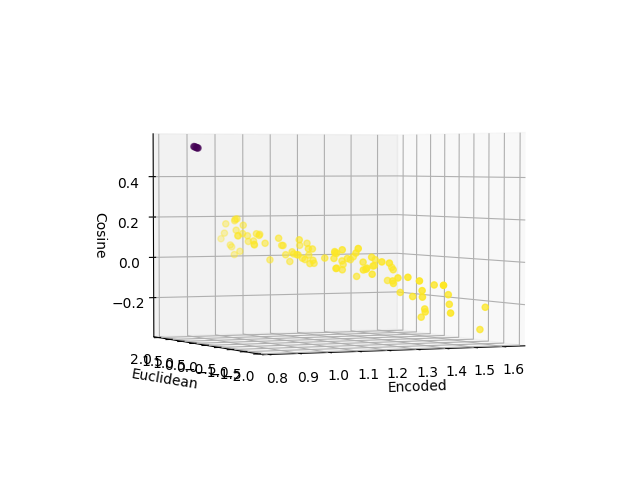

In [31]:
N = test_z.shape[0]//1

test_labels[:10]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:N,1],test_z[:N,0], test_z[:N,2], c=test_labels[:N].astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()

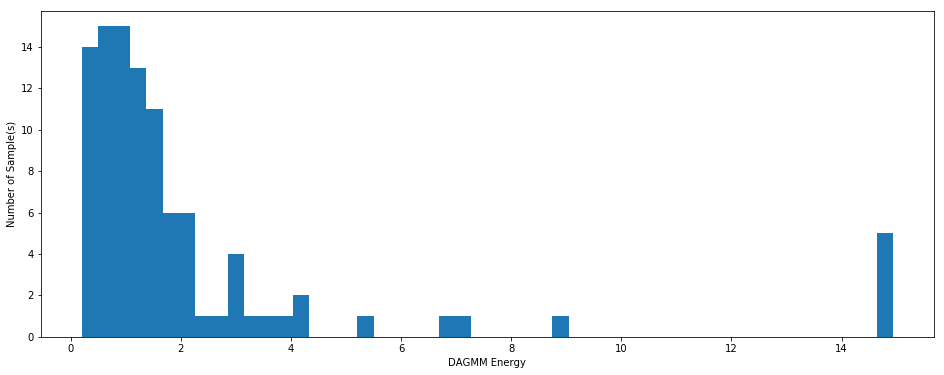

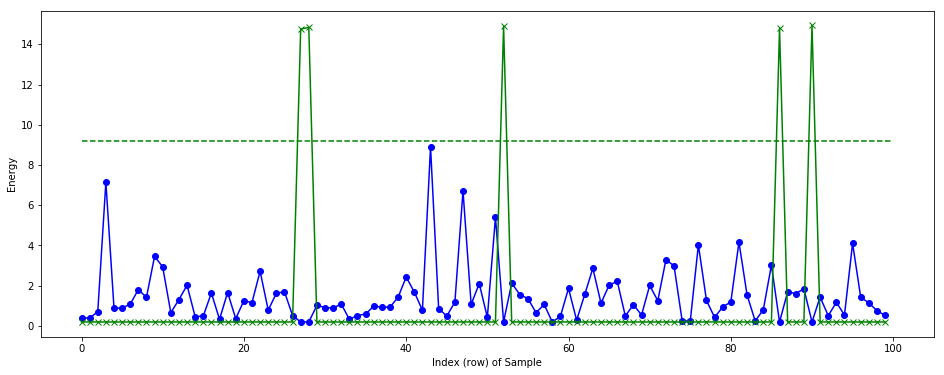

In [34]:
%matplotlib inline

energy = test_energy
anomaly_index = test_labels == 0
normal_index = test_labels == 1
data = solver.data_loader.dataset.test


plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

plt.figure(figsize=[16,6])
normal_energy = energy.copy()
anomaly_energy = energy.copy()
normal_energy[anomaly_index] = normal_energy[normal_index].min()
anomaly_energy[normal_index] = normal_energy[normal_index].min()
plt.plot(normal_energy, "o-", c='b')
plt.plot(anomaly_energy, "x-", c='g')
plt.hlines(np.percentile(energy, 95), 0, 100, 'g', linestyles='dashed', label='anomaly ')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
# plt.subplots_adjust(wspace=0.05, hspace=0.05)

# for row in range(5):
#     for col in range(5):
#         ax = axes[row, col]
#         if row != col:
#             ax.plot(data[normal_index,col], data[normal_index,row], ".", c='b')
#             ax.plot(data[anomaly_index,col], data[anomaly_index,row], ".", c='g')
#             ano_index = np.arange(len(energy))[energy > np.percentile(energy, 95)]
#             ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
# plt.tight_layout()
# # plt.savefig("./dagm2007_scatter.png")
# plt.show()

In [49]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 200,
    'batch_size' : 2,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

Elapsed 1:10:19.512886/0:00:00.928479 -- 0:00:00.928479 , Epoch [200/200], Iter [240/250], lr 0.0001, total_loss: 3.6986, sample_energy: -3.5081, recon_error: 1.5775, cov_diag: 494.3796


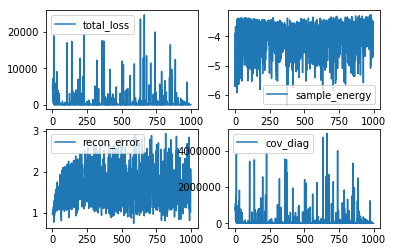

 97%|█████████▋| 243/250 [00:09<00:00, 15.40it/s]

phi tensor([0.2415, 0.2437, 0.2705, 0.2443], device='cuda:0') mu tensor([[-1.1763,  1.2019,  0.0784],
        [-1.1763,  1.2019,  0.0784],
        [-1.1763,  1.2019,  0.0784],
        [-1.1763,  1.2019,  0.0784]], device='cuda:0') cov tensor([[[ 1.7267,  0.2855, -0.1302],
         [ 0.2855,  0.0472, -0.0215],
         [-0.1302, -0.0215,  0.0098]],

        [[ 1.7267,  0.2855, -0.1302],
         [ 0.2855,  0.0472, -0.0215],
         [-0.1302, -0.0215,  0.0098]],

        [[ 1.7267,  0.2855, -0.1302],
         [ 0.2855,  0.0472, -0.0215],
         [-0.1302, -0.0215,  0.0098]],

        [[ 1.7267,  0.2855, -0.1302],
         [ 0.2855,  0.0472, -0.0215],
         [-0.1302, -0.0215,  0.0098]]], device='cuda:0')


100%|██████████| 250/250 [00:10<00:00, 24.83it/s]


======================TEST MODE======================
N: 500
phi :
 tensor([0.2415, 0.2437, 0.2705, 0.2442], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[-0.7381,  1.2905,  0.0075],
        [-0.7381,  1.2905,  0.0075],
        [-0.7381,  1.2905,  0.0075],
        [-0.7381,  1.2905,  0.0075]], device='cuda:0', grad_fn=<DivBackward0>)
cov :
 tensor([[[ 0.8671,  0.1804, -0.0850],
         [ 0.1804,  0.0413, -0.0189],
         [-0.0850, -0.0189,  0.0095]],

        [[ 0.8671,  0.1804, -0.0850],
         [ 0.1804,  0.0413, -0.0189],
         [-0.0850, -0.0189,  0.0095]],

        [[ 0.8671,  0.1804, -0.0850],
         [ 0.1804,  0.0413, -0.0189],
         [-0.0850, -0.0189,  0.0095]],

        [[ 0.8671,  0.1804, -0.0850],
         [ 0.1804,  0.0413, -0.0189],
         [-0.0850, -0.0189,  0.0095]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Threshold : 8.433275604248054
Accuracy : 0.9500, Precision : 0.9500, Recall : 1.0000, F-score : 0.9744
CPU times: user 48min 43s

In [50]:
%%time
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

In [51]:
torch.cuda.empty_cache()

In [52]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

thresh = np.percentile(combined_energy, 100 - 5/600*100)
print("Threshold :", thresh)

# 逆
pred = (test_energy<thresh).astype(int)
gt = test_labels.astype(int)

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

N: 500
phi :
 tensor([0.2415, 0.2437, 0.2705, 0.2442], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[-0.7381,  1.2905,  0.0075],
        [-0.7381,  1.2905,  0.0075],
        [-0.7381,  1.2905,  0.0075],
        [-0.7381,  1.2905,  0.0075]], device='cuda:0', grad_fn=<DivBackward0>)
cov :
 tensor([[[ 0.8817,  0.1817, -0.0852],
         [ 0.1817,  0.0409, -0.0188],
         [-0.0852, -0.0188,  0.0094]],

        [[ 0.8817,  0.1817, -0.0852],
         [ 0.1817,  0.0409, -0.0188],
         [-0.0852, -0.0188,  0.0094]],

        [[ 0.8817,  0.1817, -0.0852],
         [ 0.1817,  0.0409, -0.0188],
         [-0.0852, -0.0188,  0.0094]],

        [[ 0.8817,  0.1817, -0.0852],
         [ 0.1817,  0.0409, -0.0188],
         [-0.0852, -0.0188,  0.0094]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Threshold : 100421.76842447856
Accuracy : 1.0000, Precision : 1.0000, Recall : 1.0000, F-score : 1.0000


<IPython.core.display.Javascript object>


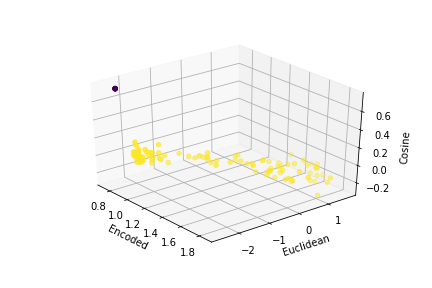

In [56]:
N = test_z.shape[0]//1

test_labels[:10]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:N,1],test_z[:N,0], test_z[:N,2], c=test_labels[:N].astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()

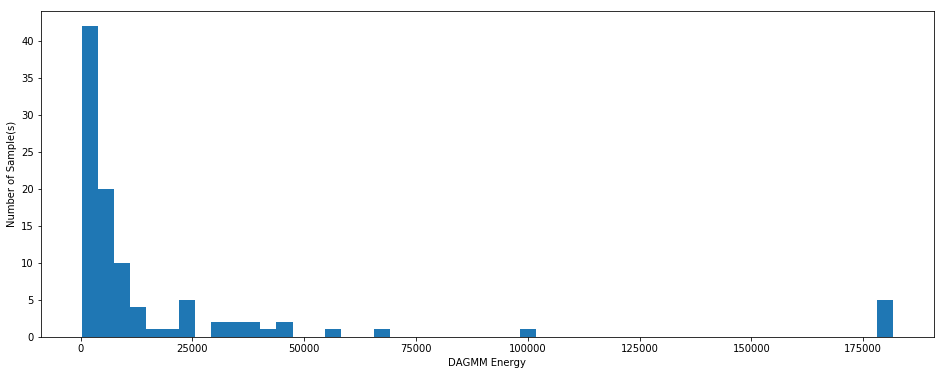

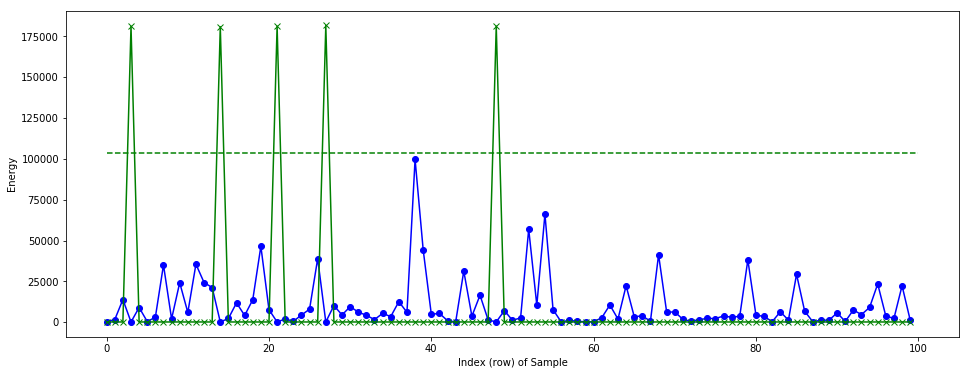

In [57]:
%matplotlib inline

energy = test_energy
anomaly_index = test_labels == 0
normal_index = test_labels == 1
data = solver.data_loader.dataset.test


plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

plt.figure(figsize=[16,6])
normal_energy = energy.copy()
anomaly_energy = energy.copy()
normal_energy[anomaly_index] = normal_energy[normal_index].min()
anomaly_energy[normal_index] = normal_energy[normal_index].min()
plt.plot(normal_energy, "o-", c='b')
plt.plot(anomaly_energy, "x-", c='g')
plt.hlines(np.percentile(energy, 95), 0, 100, 'g', linestyles='dashed', label='anomaly ')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
# plt.subplots_adjust(wspace=0.05, hspace=0.05)

# for row in range(5):
#     for col in range(5):
#         ax = axes[row, col]
#         if row != col:
#             ax.plot(data[normal_index,col], data[normal_index,row], ".", c='b')
#             ax.plot(data[anomaly_index,col], data[anomaly_index,row], ".", c='g')
#             ano_index = np.arange(len(energy))[energy > np.percentile(energy, 95)]
#             ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
# plt.tight_layout()
# # plt.savefig("./dagm2007_scatter.png")
# plt.show()

In [58]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 100,
    'batch_size' : 1,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

Elapsed 0:28:56.965857/0:00:00.729818 -- 0:00:00.729818 , Epoch [100/100], Iter [480/500], lr 0.0001, total_loss: 60000.2109, sample_energy: -7.6048, recon_error: 0.9696, cov_diag: 12000000.0000


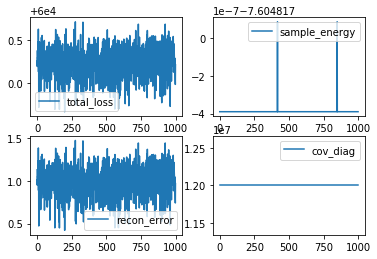

 97%|█████████▋| 486/500 [00:16<00:00, 22.94it/s]

phi tensor([0.5022, 0.0017, 0.2333, 0.2629], device='cuda:0') mu tensor([[-1.8927,  0.9699,  0.2438],
        [-1.8927,  0.9699,  0.2438],
        [-1.8927,  0.9699,  0.2438],
        [-1.8927,  0.9699,  0.2438]], device='cuda:0') cov tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.5527e-15, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], device='cuda:0')


100%|██████████| 500/500 [00:16<00:00, 29.54it/s]


======================TEST MODE======================
N: 500
phi :
 tensor([0.3877, 0.0133, 0.3080, 0.2910], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[-0.3246,  0.9882,  0.1432],
        [ 0.5508,  0.9839,  0.1682],
        [-0.1848,  0.9882,  0.1431],
        [-0.2321,  0.9882,  0.1431]], device='cuda:0', grad_fn=<DivBackward0>)
cov :
 tensor([[[ 4.1447e-16,  2.3229e-17, -2.2370e-18],
         [ 2.3229e-17,  6.3998e-16, -6.0002e-18],
         [-2.2370e-18, -6.0002e-18,  2.1018e-17]],

        [[ 4.6908e-16,  5.5187e-17,  1.3168e-18],
         [ 5.5187e-17,  8.0438e-16,  4.5006e-18],
         [ 1.3168e-18,  4.5006e-18,  2.4592e-17]],

        [[ 6.1852e-16, -7.7827e-18,  1.3198e-18],
         [-7.7827e-18,  1.3215e-15,  1.2248e-17],
         [ 1.3198e-18,  1.2248e-17,  1.4283e-17]],

        [[ 5.2526e-16,  1.3986e-17, -1.8018e-18],
         [ 1.3986e-17,  1.4337e-15, -1.3624e-17],
         [-1.8018e-18, -1.3624e-17,  1.4073e-17]]], device='cuda:0',
       grad_fn=

In [59]:
%%time
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

In [60]:
torch.cuda.empty_cache()

In [61]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

thresh = np.percentile(combined_energy, 100 - 5/600*100)
print("Threshold :", thresh)

# 逆
pred = (test_energy<thresh).astype(int)
gt = test_labels.astype(int)

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

N: 500
phi :
 tensor([0.3877, 0.0133, 0.3080, 0.2910], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[-0.3246,  0.9882,  0.1432],
        [ 0.5508,  0.9839,  0.1682],
        [-0.1848,  0.9882,  0.1431],
        [-0.2321,  0.9882,  0.1431]], device='cuda:0', grad_fn=<DivBackward0>)
cov :
 tensor([[[ 4.1447e-16,  2.3229e-17, -2.2370e-18],
         [ 2.3229e-17,  6.3998e-16, -6.0002e-18],
         [-2.2370e-18, -6.0002e-18,  2.1018e-17]],

        [[ 4.6908e-16,  5.5187e-17,  1.3168e-18],
         [ 5.5187e-17,  8.0438e-16,  4.5006e-18],
         [ 1.3168e-18,  4.5006e-18,  2.4592e-17]],

        [[ 6.1852e-16, -7.7827e-18,  1.3198e-18],
         [-7.7827e-18,  1.3215e-15,  1.2248e-17],
         [ 1.3198e-18,  1.2248e-17,  1.4283e-17]],

        [[ 5.2526e-16,  1.3986e-17, -1.8018e-18],
         [ 1.3986e-17,  1.4337e-15, -1.3624e-17],
         [-1.8018e-18, -1.3624e-17,  1.4073e-17]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Threshold : 2389950.6895833304
Accurac

<IPython.core.display.Javascript object>


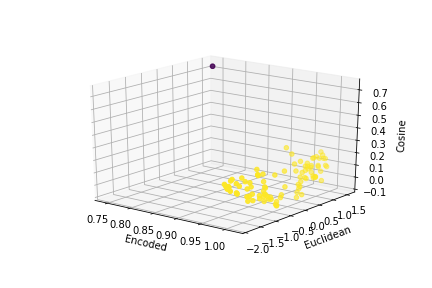

In [62]:
N = test_z.shape[0]//1

test_labels[:10]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:N,1],test_z[:N,0], test_z[:N,2], c=test_labels[:N].astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()

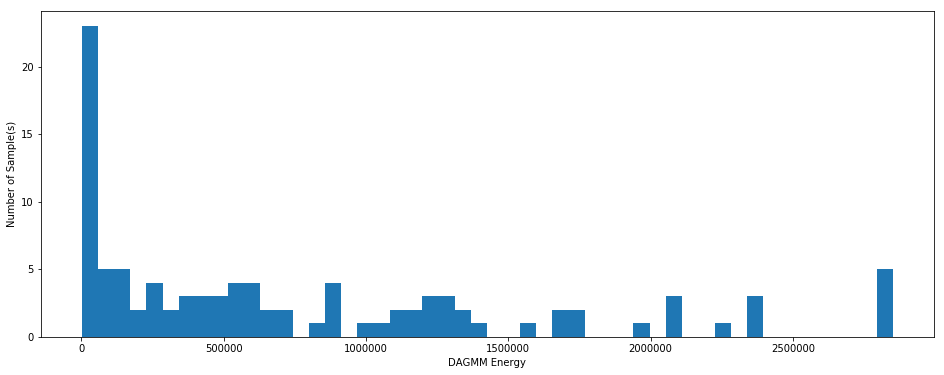

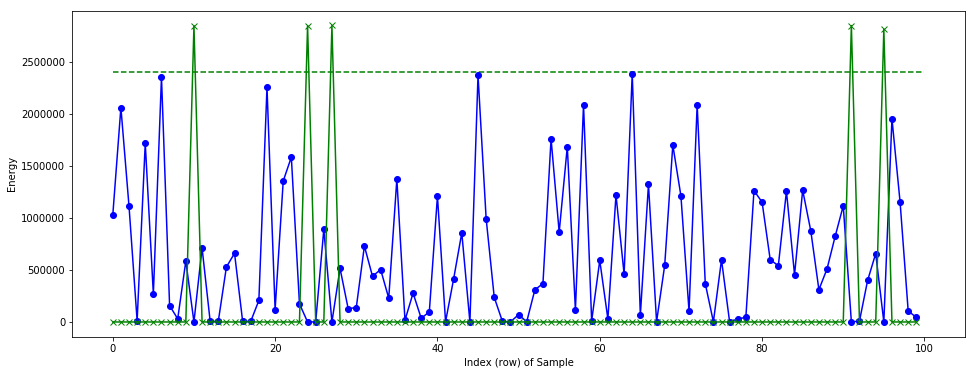

In [63]:
%matplotlib inline

energy = test_energy
anomaly_index = test_labels == 0
normal_index = test_labels == 1
data = solver.data_loader.dataset.test


plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

plt.figure(figsize=[16,6])
normal_energy = energy.copy()
anomaly_energy = energy.copy()
normal_energy[anomaly_index] = normal_energy[normal_index].min()
anomaly_energy[normal_index] = normal_energy[normal_index].min()
plt.plot(normal_energy, "o-", c='b')
plt.plot(anomaly_energy, "x-", c='g')
plt.hlines(np.percentile(energy, 95), 0, 100, 'g', linestyles='dashed', label='anomaly ')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
# plt.subplots_adjust(wspace=0.05, hspace=0.05)

# for row in range(5):
#     for col in range(5):
#         ax = axes[row, col]
#         if row != col:
#             ax.plot(data[normal_index,col], data[normal_index,row], ".", c='b')
#             ax.plot(data[anomaly_index,col], data[anomaly_index,row], ".", c='g')
#             ano_index = np.arange(len(energy))[energy > np.percentile(energy, 95)]
#             ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
# plt.tight_layout()
# # plt.savefig("./dagm2007_scatter.png")
# plt.show()